In [2]:
import numpy as np
import matplotlib
matplotlib.rcParams['image.cmap'] = 'jet'
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import time as clock
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import trange
from time import time
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from diffusion_equation import compute_solution
import xgboost as xgb
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import r2_score
import pandas as pd

In [3]:
# perm = np.load('perm.npy')
# nx0, nx1 = perm.shape
# nx2 = 1
# perm = np.reshape(perm, (nx0, nx1, nx2))
# poro = 0.1 + np.zeros((nx0, nx1, nx2))

# dx0 = 1.0 / nx0
# dx1 = 1.0 / nx1
# dx2 = 1.0 / nx2

# pwat = 2.0
# poil = 4.0
# vr = 0.3
# kwat = 1.0
# koil = 0.3

# pmin = 0.0
# pmax = 1.0

# niter = 5000
# t_final = 3.0
# dt = t_final / niter

In [7]:
niter = 100
perm = np.load('perm.npy')
nx0, nx1 = perm.shape
nx2 = 1
perm = np.reshape(perm, (nx0, nx1, nx2))
poro = 0.1 + np.zeros((nx0, nx1, nx2))

dx0 = 1.0 / nx0
dx1 = 1.0 / nx1
dx2 = 1.0 / nx2

pwat = 2.0
poil = 4.0
vr = 0.3
kwat = 1.0
koil = 0.3

pmin = 0.0
pmax = 1.0

t_final = 3.0
dt = t_final / niter

# Read from file

In [8]:
# sim_data: pres, swat, soil
# sim_data = np.load("data-100-new/sim_100.npy").astype(np.float32)#[sim_nidexes]

# pwat_list = np.load("data-100-new/pwat_100.npy").astype(np.float32)
# poil_list = np.load("data-100-new/poil_100.npy").astype(np.float32)
# kwat_list = np.load("data-100-new/kwat_100.npy").astype(np.float32)
# koil_list = np.load("data-100-new/koil_100.npy").astype(np.float32)\

In [4]:
niter = 100
nx, ny = 64, 64
t_final = 3.0
dt = t_final / niter
dx, dy = 1 / nx, 1 / ny

indexes_high = np.argwhere(sim_data[:, :, :, :, :, 1] > 0)
# indexes_low = np.argwhere((sim_data[:, :, :, :, :, 1] > 0) & (sim_data[:, :, :, :, :, 1] < 0.1))
# indexes_low = indexes_low[np.random.randint(0, indexes_low.shape[0], indexes_high.shape[0])]

indexes = indexes_high#np.vstack([indexes_low, indexes_high])
simulation_data = np.zeros((indexes.shape[0], 3))
for i, row in enumerate(indexes):
    simulation_data[i] = sim_data[row[0], row[1], row[2], row[3], row[4], :3]

x_list = indexes[:, 0] * dx
y_list = indexes[:, 1] * dy
t_list = indexes[:, 3] * dt

pwat_rand = pwat_list[indexes[:, -1]]
poil_rand = poil_list[indexes[:, -1]]
kwat_rand = kwat_list[indexes[:, -1]]
koil_rand = koil_list[indexes[:, -1]]

In [5]:
simulation_data.shape

(24856219, 3)

In [6]:
# rand_indexes_2000 = np.random.randint(0, simulation_data.shape[0], 2000)
# rand_indexes_1000 = np.random.randint(0, simulation_data.shape[0], 1000)
# rand_indexes_500 = np.random.randint(0, simulation_data.shape[0], 500)
# rand_indexes_250 = np.random.randint(0, simulation_data.shape[0], 250)

# np.save('train-indexes-2000.npy', rand_indexes_2000)
# np.save('train-indexes-1000.npy', rand_indexes_1000)
# np.save('train-indexes-500.npy', rand_indexes_500)
# np.save('train-indexes-250.npy', rand_indexes_250)


rand_indexes_2000 = np.load('train-indexes-2000.npy')
rand_indexes_1000 = np.load('train-indexes-1000.npy')
rand_indexes_500 = np.load('train-indexes-500.npy')
rand_indexes_250 = np.load('train-indexes-250.npy')

In [7]:
rand_indexes = rand_indexes_500

simulation_data_train = simulation_data.astype(np.float32)[rand_indexes]

x = x_list.astype(np.float32)[rand_indexes]
y = y_list.astype(np.float32)[rand_indexes]
t = t_list.astype(np.float32)[rand_indexes]


pwat = pwat_rand.astype(np.float32)[rand_indexes]
poil = poil_rand.astype(np.float32)[rand_indexes]
kwat = kwat_rand.astype(np.float32)[rand_indexes]
koil = koil_rand.astype(np.float32)[rand_indexes]

points = np.stack((t, x, y, pwat, poil, kwat, koil), -1)

In [8]:
pd.DataFrame(data=simulation_data_train, columns=['pres', 'swat', 'soil']).describe()

,pres,swat,soil
count,500.000000,5.000000e+02,500.000000
mean,0.560979,6.015044e-02,0.939850
std,0.340489,1.200004e-01,0.120000
min,0.003027,5.244668e-40,0.529817
25%,0.214516,7.419573e-36,0.995917
50%,0.659218,2.569070e-31,1.000000
75%,0.880536,4.083102e-03,1.000000
max,0.994796,4.701834e-01,1.000000


In [9]:
X_train, y_train = points, simulation_data_train

# Initialazing XGBoost model

In [10]:
xgb_regressor = xgb.XGBRegressor(tree_method='hist', verbosity=2)
multioutput_regressor = MultiOutputRegressor(xgb_regressor)
multioutput_regressor.fit(X_train, y_train)

[13:52:21] INFO: /Users/runner/work/xgboost/xgboost/src/data/iterative_dmatrix.cc:53: Finished constructing the `IterativeDMatrix`: (500, 7, 3500).
[13:52:21] INFO: /Users/runner/work/xgboost/xgboost/src/data/iterative_dmatrix.cc:53: Finished constructing the `IterativeDMatrix`: (500, 7, 3500).
[13:52:21] INFO: /Users/runner/work/xgboost/xgboost/src/data/iterative_dmatrix.cc:53: Finished constructing the `IterativeDMatrix`: (500, 7, 3500).


MultiOutputRegressor(estimator=XGBRegressor(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None,
                                            feature_weights=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=None, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=None,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=None, n_jobs=None,
                                            num_parallel_tree=None, ...))

In [11]:
mean_squared_error(multioutput_regressor.predict(X_train), y_train)

1.1512551054693176e-06

In [12]:
def main_new(multioutput_regressor, pwat=1.5, poil=4.0, kwat=1.0, koil = 0.3):
    perm = np.load('perm.npy')
    nx0, nx1 = perm.shape
    nx2 = 1
    perm = np.reshape(perm, (nx0, nx1, nx2))
    poro = 0.1 + np.zeros((nx0, nx1, nx2))

    dx0 = 1.0 / nx0
    dx1 = 1.0 / nx1
    dx2 = 1.0 / nx2
    vr = 0.3
    
    if isinstance(pwat, float):
        pwat_list = pwat * torch.ones(64 * 64)
        poil_list = poil * torch.ones(64 * 64)
        kwat_list = kwat * torch.ones(64 * 64)
        koil_list = koil * torch.ones(64 * 64)

    pmin = 0.0
    pmax = 1.0

    dt = 0.15e-1
    niter = 100


    swat = np.zeros((nx0, nx1, nx2))
    soil = np.ones((nx0, nx1, nx2))


    pres, swat, soil = compute_solution(perm, poro,
                                        dx0, dx1, dx2, dt * niter, niter,
                                        pwat, kwat, poil, koil, vr,
                                        pmin=0.0, pmax=1.0)
    
    time_for_model = (niter * dt) * torch.ones(64 * 64)
    x_for_model = dx0 * torch.arange(64)
    y_for_model = dx1 * torch.arange(64)
    cartesian_points = torch.cartesian_prod(x_for_model, y_for_model)

    model_prediction = multioutput_regressor.predict(np.stack((
        time_for_model, 
        cartesian_points[:, 0], 
        cartesian_points[:, 1],
        pwat * np.ones(64 * 64),
        poil * np.ones(64 * 64),
        kwat * np.ones(64 * 64),
        koil * np.ones(64 * 64)), -1))    
    
    plt.figure()
    plt.title('Water saturation, simulator')
    plt.imshow(swat[:, :, :, -1])
    plt.colorbar()
    plt.xlabel('x')
    plt.ylabel('y')
    plt.savefig('color_swat_sim.png')
    plt.show()
    
    plt.figure()
    plt.title('Water saturation, XGB')
    plt.imshow(model_prediction[:, 1].reshape(nx0, nx1, nx2))
    plt.colorbar()
    plt.xlabel('x')
    plt.ylabel('y')
    plt.savefig('color_swat_xgb3.png')
    plt.show()
    
    plt.figure()
    plt.title('Pressure, simulator')
    plt.imshow(pres[:, :, :, -1])
    plt.colorbar()
    plt.xlabel('x')
    plt.ylabel('y')
    plt.savefig('color_pressure_sim.png')
    plt.show()
    

    plt.figure()
    plt.title('Pressure, XGB')
    plt.imshow(model_prediction[:, 0].reshape(nx0, nx1, nx2))
    plt.colorbar()
    plt.xlabel('x')
    plt.ylabel('y')
    plt.savefig('color_pressure_xgb3.png')
    plt.show()    
    
    
    plt.figure()
    plt.title('Water saturation at t = 0')
    plt.scatter(np.linspace(0.0, 1.0, nx0), swat[:, 0, 0, -1], label='Simulator')
    plt.scatter(np.linspace(0.0, 1.0, nx0), model_prediction[:, 1].reshape(nx0, nx1, nx2)[:, 0, 0], label='XGB')
    plt.grid()
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend()
    plt.savefig('swat_scatter_xgb3.png')
    plt.show()


    plt.figure()
    plt.title('Pressure at t = 0')
    plt.scatter(np.linspace(0.0, 1.0, nx0), pres[:, 0, 0, -1], label='Simulator')
    plt.scatter(np.linspace(0.0, 1.0, nx0), model_prediction[:, 0].reshape(nx0, nx1, nx2)[:, 0, 0], label='XGB')
    plt.grid()
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend()
    plt.savefig('pres_scatter_xgb_3.png')
    plt.show()

    return 0

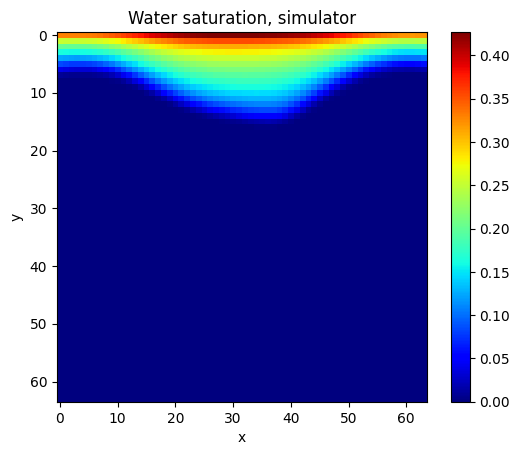

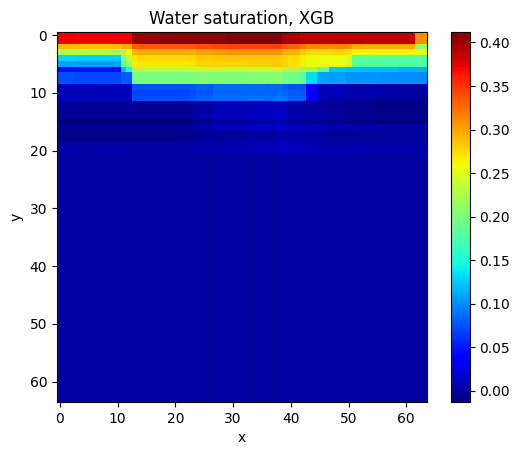

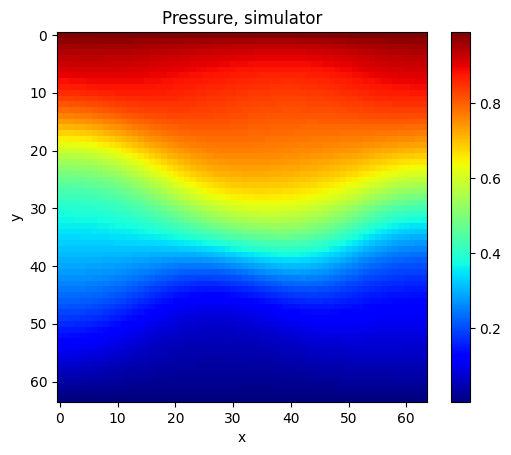

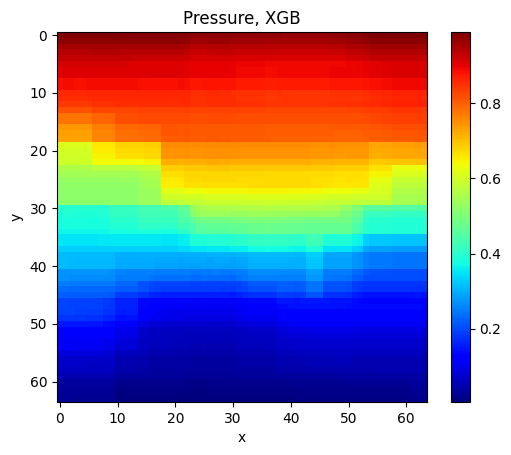

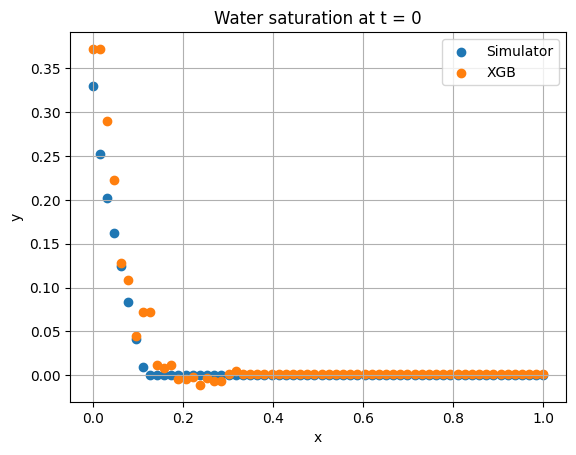

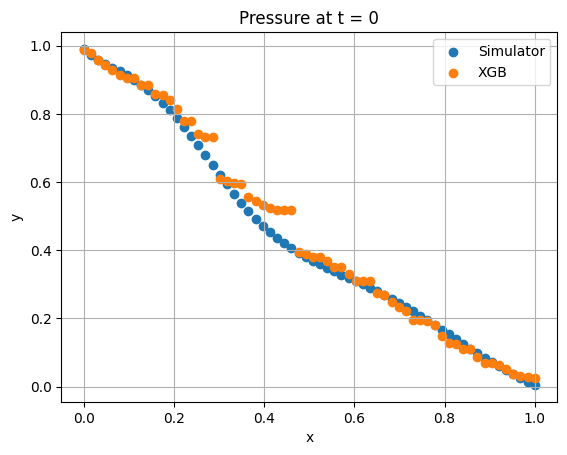

0

In [13]:
main_new(multioutput_regressor)

# Test models

In [14]:
def build_metrics(model_prediction, pres, swat, soil, process):

    metrics = ['MSE', 'MAE', 'R_2', 'RMSE', 'MAPE']
    
    # Saturation water
    satur = [
        np.mean((model_prediction[:, 2] - swat) ** 2),  # MSE
        np.mean(np.abs(model_prediction[:, 2] - swat)), # MAE
        r2_score(swat, model_prediction[:, 2]),         # R^2
        np.sqrt(np.mean((model_prediction[:, 2] - swat) ** 2)), # RMSE
        np.mean(np.abs((swat - model_prediction[:, 2]) / (swat + 1e-8))) * 100  # MAPE (%)
    ]
    
    # Pressure
    press = [
        np.mean((model_prediction[:, 0] - pres) ** 2),
        np.mean(np.abs(model_prediction[:, 0] - pres)),
        r2_score(pres, model_prediction[:, 0]),
        np.sqrt(np.mean((model_prediction[:, 0] - pres) ** 2)),
        np.mean(np.abs((pres - model_prediction[:, 0]) / (pres + 1e-8))) * 100
    ]
    
    # Saturation oil
    sat_oil = [
        np.mean((model_prediction[:, 1] - soil) ** 2),
        np.mean(np.abs(model_prediction[:, 1] - soil)),
        r2_score(soil, model_prediction[:, 1]),
        np.sqrt(np.mean((model_prediction[:, 1] - soil) ** 2)),
        np.mean(np.abs((soil - model_prediction[:, 1]) / (soil + 1e-8))) * 100
    ]
    
    # Combine into dataframe
    metrics_df = pd.DataFrame({
        f'Metrics {process}': metrics,
        f'Saturation water {process}': satur,
        f'Saturation oil {process}': sat_oil,
        f'Pressure {process}': press
    })
    
    return metrics_df


In [15]:
def build_test_random(model, x_list=x_list, y_list=y_list, 
               t_list=t_list, pwat_rand=pwat_rand,
               poil_rand=poil_rand, kwat_rand=kwat_rand, 
               koil_rand=koil_rand, simulation_data=simulation_data, 
               dx=dx, dy=dy, dt=dt, rand_indexes=rand_indexes, test_size=100):

    N = simulation_data.shape[0] - rand_indexes.shape[0]
    test_indexes = np.random.randint(0, N, test_size)
    pres = np.delete(simulation_data[:, 0], rand_indexes)[test_indexes]
    swat = np.delete(simulation_data[:, 1], rand_indexes)[test_indexes]
    soil = np.delete(simulation_data[:, 2], rand_indexes)[test_indexes]

    x_list = np.delete(x_list, rand_indexes)[test_indexes] * dx
    y_list = np.delete(y_list, rand_indexes)[test_indexes] * dy
    t_list = np.delete(t_list, rand_indexes)[test_indexes] * dt

    pwat_rand = np.delete(pwat_rand, rand_indexes)[test_indexes]
    poil_rand = np.delete(poil_rand, rand_indexes)[test_indexes]
    kwat_rand = np.delete(kwat_rand, rand_indexes)[test_indexes]
    koil_rand = np.delete(koil_rand, rand_indexes)[test_indexes]

    # Build (N, 7) input matrix
    X = np.column_stack([
        t_list.astype(np.float32),
        x_list.astype(np.float32),
        y_list.astype(np.float32),
        pwat_rand.astype(np.float32),
        poil_rand.astype(np.float32),
        kwat_rand.astype(np.float32),
        koil_rand.astype(np.float32),
    ])

    model_prediction = model.predict(X)  

    return model_prediction, pres, swat, soil


In [16]:
model_prediction, pres, swat, soil = build_test_random(multioutput_regressor)
build_metrics(model_prediction, pres, swat, soil, 'test random')

,Metrics test random,Saturation water test random,Saturation oil test random,Pressure test random
0,MSE,6.498812e-01,0.649881,0.305837
1,MAE,7.974679e-01,0.797468,0.440089
2,R_2,-4.602412e+01,-46.024127,-1.732264
3,RMSE,8.061521e-01,0.806152,0.553025
4,MAPE,6.332092e+09,84.314167,619.661713


# Test result real sim

In [17]:
def build_test_sim(model, dt=0.15e-1, niter=100, 
                   perm=perm, dx=dx, dy=dy,
                   pwat=1.4, poil=5.0, 
                   kwat=1.0, koil=0.5,
                   vr=0.3):
    
    pwat_list = pwat * torch.ones(64 * 64)
    poil_list = poil * torch.ones(64 * 64)
    kwat_list = kwat * torch.ones(64 * 64)
    koil_list = koil * torch.ones(64 * 64)
    
    
    swat = np.zeros((nx0, nx1, nx2))
    soil = np.ones((nx0, nx1, nx2))
    
    
    pres, swat, soil = compute_solution(perm, poro,
                                        dx0, dx1, dx2, dt * niter, niter,
                                        pwat, kwat, poil, koil, vr,
                                        pmin=0.0, pmax=1.0)
    
    time_for_model = (niter * dt) * torch.ones(64 * 64)
    x_for_model = dx0 * torch.arange(64)
    y_for_model = dx1 * torch.arange(64)
    cartesian_points = torch.cartesian_prod(x_for_model, y_for_model)

    model_prediction = model.predict(np.stack((
        time_for_model, 
        cartesian_points[:, 0], 
        cartesian_points[:, 1],
        pwat_list,
        poil_list,
        kwat_list,
        koil_list), -1))  
    
    return model_prediction, pres, swat, soil

In [18]:
model_prediction, pres, swat, soil = build_test_sim(multioutput_regressor, dt=0.3e-1, niter=100,)


sw_pred = model_prediction[:, 1].reshape(nx0, nx1, nx2)[:, 0, 0]
sw_true = swat[:, 0, 0, -1]

so_pred = model_prediction[:, 2].reshape(nx0, nx1, nx2)[:, 0, 0]
so_true = soil[:, 0, 0, -1]

p_pred  = model_prediction[:, 0].reshape(nx0, nx1, nx2)[:, 0, 0]
p_true  = pres[:, 0, 0, -1]

metrics = ['MSE', 'MAE', 'R_2', 'RMSE', 'MAPE']

# Helper to compute all metrics with safe MAPE
def all_metrics(y_true, y_pred, eps=1e-8):
    mse  = np.mean((y_pred - y_true) ** 2)
    mae  = np.mean(np.abs(y_pred - y_true))
    r2   = r2_score(y_true, y_pred)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((y_true - y_pred) / (np.abs(y_true) + eps))) * 100.0
    return [mse, mae, r2, rmse, mape]

# Build columns
satur = all_metrics(sw_true, sw_pred)   # Saturation water
sat_oil = all_metrics(so_true, so_pred)   # Saturation oil
press = all_metrics(p_true,  p_pred)    # Pressure

# Combine into dataframe
metrics_df = pd.DataFrame({
    f'Metrics test': metrics,
    f'Saturation test': satur,
    f'Saturation oil test': sat_oil,
    f'Pressure test': press
})

metrics_df

,Metrics test,Saturation test,Saturation oil test,Pressure test
0,MSE,3.406667e-03,0.003407,0.001181
1,MAE,2.912972e-02,0.029130,0.024564
2,R_2,2.848899e-01,0.284891,0.987381
3,RMSE,5.836666e-02,0.058367,0.034371
4,MAPE,6.782743e+07,3.257423,20.053982


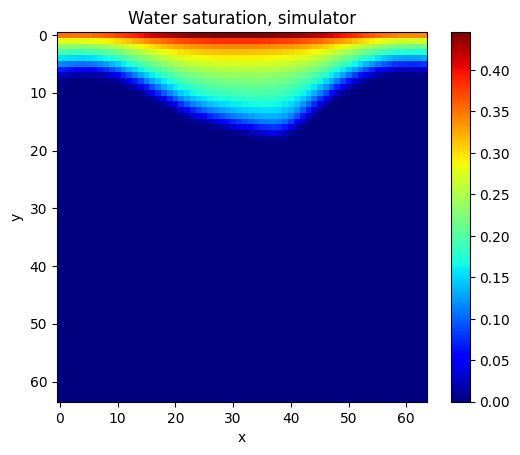

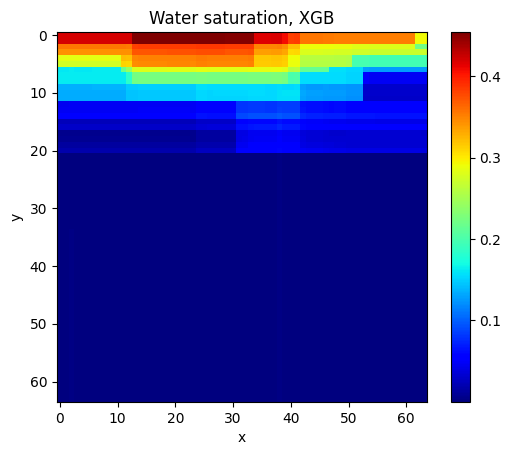

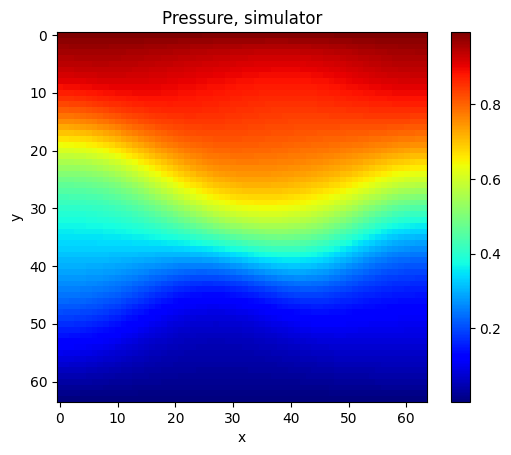

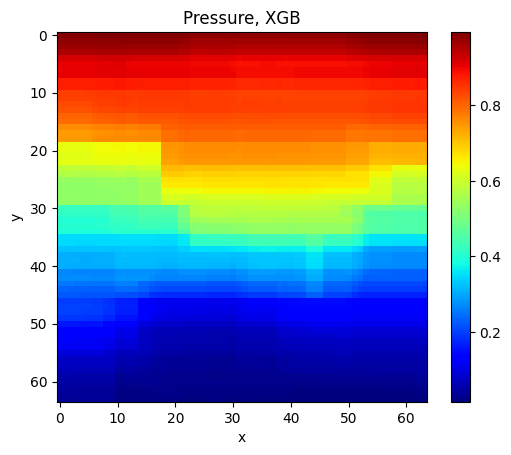

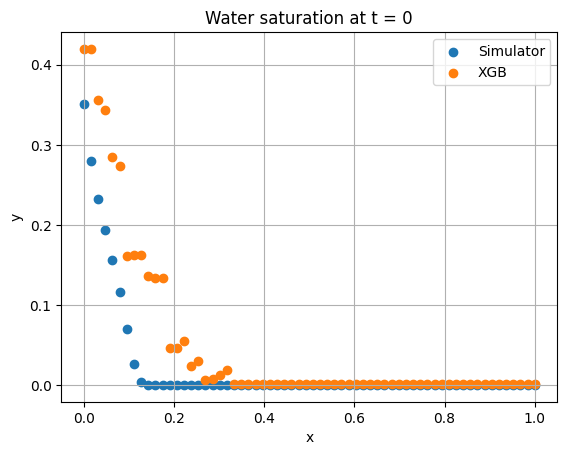

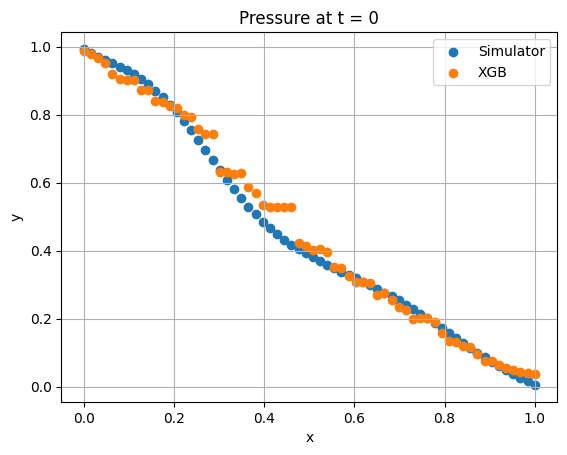

In [19]:
plt.figure()
plt.title('Water saturation, simulator')
plt.imshow(swat[:, :, :, -1])
plt.colorbar()
plt.xlabel('x')
plt.ylabel('y')
plt.show()

plt.figure()
plt.title('Water saturation, XGB')
plt.imshow(model_prediction[:, 1].reshape(nx0, nx1, nx2))
plt.colorbar()
plt.xlabel('x')
plt.ylabel('y')
plt.show()

plt.figure()
plt.title('Pressure, simulator')
plt.imshow(pres[:, :, :, -1])
plt.colorbar()
plt.xlabel('x')
plt.ylabel('y')
plt.show()


plt.figure()
plt.title('Pressure, XGB')
plt.imshow(model_prediction[:, 0].reshape(nx0, nx1, nx2))
plt.colorbar()
plt.xlabel('x')
plt.ylabel('y')
plt.show()    


plt.figure()
plt.title('Water saturation at t = 0')
plt.scatter(np.linspace(0.0, 1.0, nx0), swat[:, 0, 0, -1], label='Simulator')
plt.scatter(np.linspace(0.0, 1.0, nx0), model_prediction[:, 1].reshape(nx0, nx1, nx2)[:, 0, 0], label='XGB')
plt.grid()
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()


plt.figure()
plt.title('Pressure at t = 0')
plt.scatter(np.linspace(0.0, 1.0, nx0), pres[:, 0, 0, -1], label='Simulator')
plt.scatter(np.linspace(0.0, 1.0, nx0), model_prediction[:, 0].reshape(nx0, nx1, nx2)[:, 0, 0], label='XGB')
plt.grid()
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()